In [1]:
from quantile_regression.entropic_optimal_transport import EntropicOTQuantileRegression
from old_source_code.data import create_joint_x_y
import torch
from utils import TrainParams

X, Y = create_joint_x_y(1000)
X_dataset = torch.from_numpy(X)
Y_dataset = torch.from_numpy(Y)
device_and_dtype_specifications = dict(
    dtype=torch.float64,
    device=torch.device("cpu")
)

X_dataset = X_dataset.to(**device_and_dtype_specifications)
Y_dataset = Y_dataset.to(**device_and_dtype_specifications)

dataloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_dataset, Y_dataset), batch_size=256, shuffle=True)
train_params = TrainParams(num_epochs=500, learning_rate=1e-2, verbose=True)
eotqr = EntropicOTQuantileRegression(
    feature_dimension=X_dataset.shape[1],
    response_dimension=Y_dataset.shape[1],
    hidden_dimension=8,
    number_of_hidden_layers=4,
    epsilon=1e-7
)

eotqr.to(**device_and_dtype_specifications)
_ = eotqr.fit(dataloader, train_params=train_params)

# # to save the model:
# eotqr.save("eotqr.pth")

# to load the model:
# _ = eotqr.load("eotqr.pth")

Epoch: 500, objective: 1.256: 100%|██████████| 500/500 [11:21<00:00,  1.36s/it]


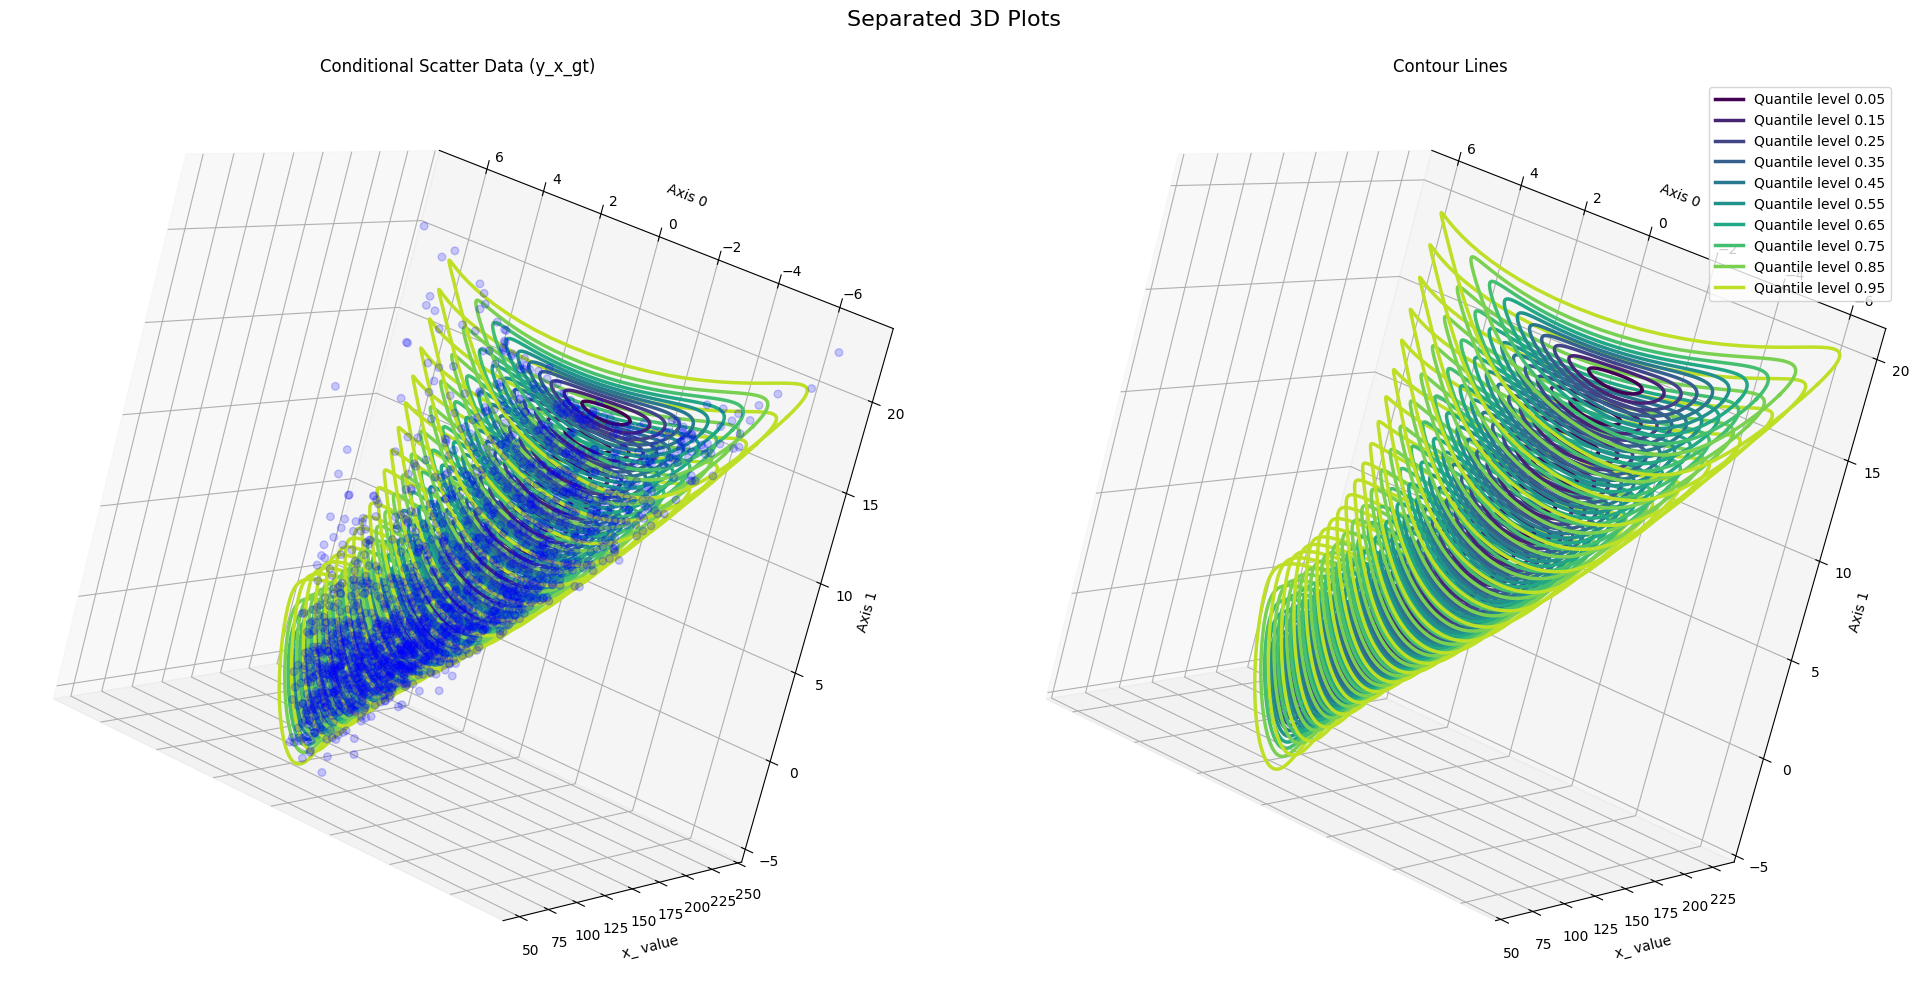

In [2]:
%matplotlib inline
from utils import plot_potentials_from_banana_dataset

eotqr.eval()
plot_potentials_from_banana_dataset(model=eotqr, device_and_dtype_specifications=device_and_dtype_specifications)